In [19]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
from copy import deepcopy
import itertools as it
import glob 
import h5py
import json
import gc

import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.utils import dense_to_sparse

from sca import *
from utils import *
from models_uf import *
import dataset as ds


def classical_SCA(X, mu, Pc, init='last', **kwargs):
    
    kwargs['SolverMaxIter'] = kwargs['SolverMaxIter'] if 'SolverMaxIter' in kwargs else 100
    kwargs['MaxIter'] = kwargs['MaxIter'] if 'MaxIter' in kwargs else 100
    kwargs['parm_alpha'] = kwargs['parm_alpha'] if 'parm_alpha' in kwargs else 0.01
    kwargs['RelTolFun'] = kwargs['RelTolFun'] if 'RelTolFun' in kwargs else 1e-12
    kwargs['RelTolVal'] = kwargs['RelTolVal'] if 'RelTolVal' in kwargs else 1e-12
    kwargs['InnerOpt'] = kwargs['InnerOpt'] if 'InnerOpt' in kwargs else 'sgd'
    
    n, d = X.shape
    nue = int(d**.5)
    assert nue**2+nue+1 == d

    xx = None
    gc.collect()
    xx = deepcopy(X)
    
    p0_valid, hs_valid, pmax_valid = [item.cpu().numpy() for item in decouple_input(xx, nue)]

    eeval, ppred = [],[]
    with tqdm(total=n)  as pbar:       
        for ni in range(n):
            if ni==0 or pmax_valid[ni-1] > pmax_valid[ni] or init in ['full','max'] :
                p0 = p0_valid[ni]
            elif init=='last':
                p0 = P[-1]
            else:
                raise ValueError('Initialization error!')
                
            h = hs_valid[ni]
            O, P = SCA(h, mu = mu, Pc = Pc, Pmax = pmax_valid[ni], pt = p0, **kwargs)
            
            if np.isnan(O[-1]):
                P[-1] = p0_valid[ni]
                O[-1] = f_wsee(P[-1], h, mu, Pc)

            if np.isnan(O[-1]):
                raise

            eeval.append(O[-1])
            ppred.append(P[-1])
            
            pbar.update(1)
            pbar.set_description("WSEE %.6f" % np.mean(eeval))
            
        #     print(O[-1], P[-1])
    return np.array(eeval), np.array(ppred)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.random.uniform(low=0.0, high=[[1,2,3],[4,5,6]])

array([[0.09102803, 0.41705812, 1.10686666],
       [2.48888252, 1.51635456, 5.50361969]])

## Prepare data and SCA benchmarks

### (1) load data

In [3]:

num_ue=4
init = 'full'
device = torch.device('cuda')


dfn_tr = '../../data/results_hataUrban_noSF.h5' # train / validation data
X_tr, y_tr, cinfo_tr = ds.load_data(dfn_tr)
print(X_tr.shape, y_tr.shape)

dfn_te = '../../data/results_hataUrban.h5' # test data
X_te, y_te, cinfo_te = ds.load_data(dfn_te)
print(X_te.shape, y_te.shape)

# to torch tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_te = torch.from_numpy(y_te).float().to(device)

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((init_p(x[:,-1], num_ue, method=init), x))).float().to(device)
X_tr_ = attach_pt(X_tr)
X_te_ = attach_pt(X_te)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items() }
cinfo_tr = dict_to_device(cinfo_tr, device)
cinfo_te = dict_to_device(cinfo_te, device)

# SCA PERFORMANCES: PREPARED BY RUNNING THE NEXT SESSION 
wsee_sca_tr = np.load(dfn_tr.split('.h5')[0]+'_fSCAobj.npy')
wsee_sca_te = np.load(dfn_te.split('.h5')[0]+'_fSCAobj.npy')
print(np.mean(wsee_sca_tr), np.mean(wsee_sca_te))

2021-01-10 20:40:29 | (51000, 17) (51000, 4)
2021-01-10 20:40:29 | (51000, 17) (51000, 4)
2021-01-10 20:40:31 | 7.803645 9.091745


In [2]:
#--- data---

num_ue=10
init = 'full'
device = torch.device('cuda')


dfn_tr = '../../data_my/channels-hataSuburban-10.h5' # train / validation data
X_tr, y_tr, cinfo_tr = ds.load_data_unsup(dfn_tr)
print(X_tr.shape, y_tr.shape)

dfn_te = '../../data_my/channels-hataUrban-10.h5' # test data, different distribution from train/val
X_te, y_te, cinfo_te = ds.load_data_unsup(dfn_te)
print(X_te.shape, y_te.shape)

dfn_disp = '../../data_my/test-channels-hataSuburban-10.h5' # same distribution as train/val, but unseen data
X_disp, y_disp, cinfo_disp = ds.load_data_unsup(dfn_disp)
print(X_disp.shape, y_disp.shape)

# to torch tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_te = torch.from_numpy(y_te).float().to(device)
y_disp = torch.from_numpy(y_disp).float().to(device)

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((init_p(x[:,-1], num_ue, method=init), x))).float().to(device)
X_tr_ = attach_pt(X_tr)
X_te_ = attach_pt(X_te)
X_disp_ = attach_pt(X_disp)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items()}
cinfo_tr = dict_to_device(cinfo_tr, device)
cinfo_te = dict_to_device(cinfo_te, device)
cinfo_disp = dict_to_device(cinfo_disp, device)

# SCA PERFORMANCES: PREPARED BY RUNNING THE NEXT SESSION 
wsee_sca_tr = np.load(dfn_tr.split('.h5')[0]+'_fSCA+obj+p.npz')['wsee']
wsee_sca_te = np.load(dfn_te.split('.h5')[0]+'_fSCA+obj+p.npz')['wsee']
wsee_sca_disp = np.load(dfn_disp.split('.h5')[0]+'_fSCA+obj+p.npz')['wsee']

print(np.mean(wsee_sca_tr), np.mean(wsee_sca_te), np.mean(wsee_sca_disp))

2021-01-16 14:31:04 | (51000, 101) (51000, 10)
2021-01-16 14:31:04 | (51000, 101) (51000, 10)
2021-01-16 14:31:05 | (51000, 101) (51000, 10)
2021-01-16 14:31:06 | 11.345977 8.192833 11.036331


In [303]:
"""
load model and predict 
"""

def allocate(model, data, edge_index=None):
    bs = data.shape[0]
    num_ue = int((data.shape[1]-1)**.5)
    
    if edge_index is not None:
        shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long().to(edge_index.device) 
        edge_index_batch = edge_index.repeat(1, bs)+shift #edge_index_tr=edge_index_va

        #y_init, edge_weight_batch, _ = 
        y_init =  data[:,:num_ue].reshape(-1,1) # inital signals (p_init)
        y_constr = data[:,:num_ue].reshape(-1,1) # upper power constraint (p_max)

        edge_weight_batch = (data[:,num_ue:-1]/data[:,-1].view(-1,1)).reshape(-1)
#         edge_weight_batch = (data[:,num_ue:-1]).reshape(-1)
        input = [ (y_init, y_constr), edge_index_batch, edge_weight_batch ] 
    else:
        input = [ data[:,:]]#-(num_ue**2+1)] ]
    
    pred = model(*input)
    
    if isinstance(pred, tuple):
        pred = pred[0]
    if isinstance(pred, list):
        pred = pred[-1]
    return pred.view(-1, num_ue)
    
    
data = X_te_ # X_te_ | X_disp_
ei = cinfo_disp['edge_index']
wsee_plot = wsee_sca_te # wsee_sca_te | wsee_sca_disp
print(data.shape)

fk='[0,1]'
keys = ['GCN-USCA(max)','GCN-USCA(rand)', 'MLP-USCA|wsee', 'GCN-Vanilla|wsee(max)','GCN-Vanilla|wsee(rand)', 'MLP-Vanilla|wsee']
files = [
    glob.glob(glob_escape_except('./runs_10_test_corr/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/')+f'{fk}/model.pt'),
    glob.glob(glob_escape_except('./runs_10_rand/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+5.00e-04_l2+1.00e-06_pinit+rand_loss+wsee_rseed+42/')+f'{fk}/model.pt'),
    glob.glob(glob_escape_except('./runs_10/USCA.MLP+learned.mlp_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/')+f'{fk}/model.pt'),
    glob.glob(glob_escape_except('./runs_10_test/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/')+f'{fk}/model.pt'),
    glob.glob(glob_escape_except('./runs_10_rand/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+rand_loss+wsee_rseed+42/')+f'{fk}/model.pt'),
    glob.glob(glob_escape_except('./runs_10/MLP.ChPm+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+5.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/')+f'{fk}/model.pt')
]

wsee_pred = {}
for m, tl_list in zip(keys, files):
    wsee_pred[m] = []
    for lf in tl_list:
        torch.cuda.empty_cache()
        model_load = torch.load(lf)['net']

        with torch.no_grad():
            if 'GCN' in m:
                y_pred = allocate(model_load, data, ei)
            elif 'MLP' in m:
                y_pred = allocate(model_load, data, None)
            else:
                raise

        y_pred = y_pred.view(-1,num_ue)
        wsee_pred[m].append(f_wsee_torch(y_pred, data, 4,1, 'none').sum(1).cpu().numpy())
# wsee

2021-01-18 20:44:30 | torch.Size([51000, 111])


Text(0.5, 1.0, 'hataUrban (test)')

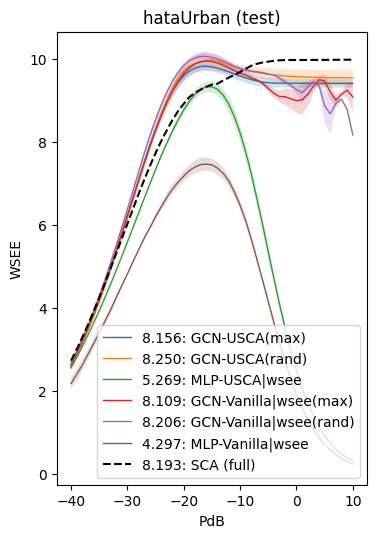

In [305]:

# plot saturation
fig, ax = plt.subplots(1,1,figsize=(4,6), dpi=100)
pdb = np.array(range(-40,10+1,1))

for i, (m, val) in enumerate(wsee_pred.items()):
    wval = np.nanmean(np.array(val).reshape(len(val), -1, 51), 1)    
    plot_shaded(x=pdb, y=wval, ax=ax, label='%.3f: %s'%(np.nanmean(wval), m), color=colors[i]) 
    
plt.plot(pdb, np.nanmean(wsee_plot.reshape(-1,51), 0), 'k--', label='%.3f: SCA (full)'%np.nanmean(wsee_plot))#.mean(0))
    
plt.legend()
plt.xlabel('PdB')
plt.ylabel('WSEE')
# plt.title('hataSuburban (val)')
plt.title('hataUrban (test)')

### ~~(2) save classical SCA performance (NO NEED TO RUN AGAIN, JUST LOAD)~~
results saved to: 
`../../data/results_hataUrban_noSF_fSCA+obj+p.npz` &
`../../data/results_hataUrban_fSCA+obj+p.npz`

see `scripts/sca_run.py`

In [38]:
inner_layers=[32,16,8]
k_fold, fk = 2, 0

inner_layers_str = str(inner_layers).replace(' ','')


# split train, val, test sets, same as run
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.ones(y_tr.shape[0], dtype=bool))):
    if k==fk:
        # full sca
        wsee_sca = {'tr': np.nanmean(wsee_sca_tr[train_index]), 
                    'va': np.nanmean(wsee_sca_tr[valid_index]),
                    'te': np.nanmean(wsee_sca_te[valid_index])}        
#         # truncated sca
#         args = {'mu':cinfo_tr['mu'], 'Pc':cinfo_tr['Pc'], 'init':'last', 
#                 'SolverMaxIter':len(inner_layers), 'MaxIter':1}
#         wsee_sca_trunc = {'tr': np.nanmean(classical_SCA(X_tr_[train_index], **args)[0]), 
#                           'va': np.nanmean(classical_SCA(X_tr_[valid_index], **args)[0]), 
#                           'te': np.nanmean(classical_SCA(X_te_[valid_index], **args)[0])}


## load from log files and visualize 

In [4]:
import re
from glob import glob
log_files = sorted(glob('./runs*/USCA.MLP+*+mse+wsee*/0/logs.json'))

res_mat = np.empty((10,10,3))
res_mat.fill(np.nan)

npmap = {32:0, 64:1, 128:2}

out_num, in_num = [],[]

for logf in log_files:
    regp = re.findall('nl\+(\d)\+(\d)\+\[(\d+)', logf)
        
    try:
        n_out , n_in, n_param = [int(r) for r in regp[0]]
    except:
        continue
    
#     if n_out in out_num and n_in in in_num:
#         continue
        
    out_num.append(n_out)
    in_num.append(n_in)

    with open(logf) as f:
        ss=json.load(f)
        
    res_mat[n_out , n_in, npmap[n_param]] = max(ss['wsee']['va'])
    


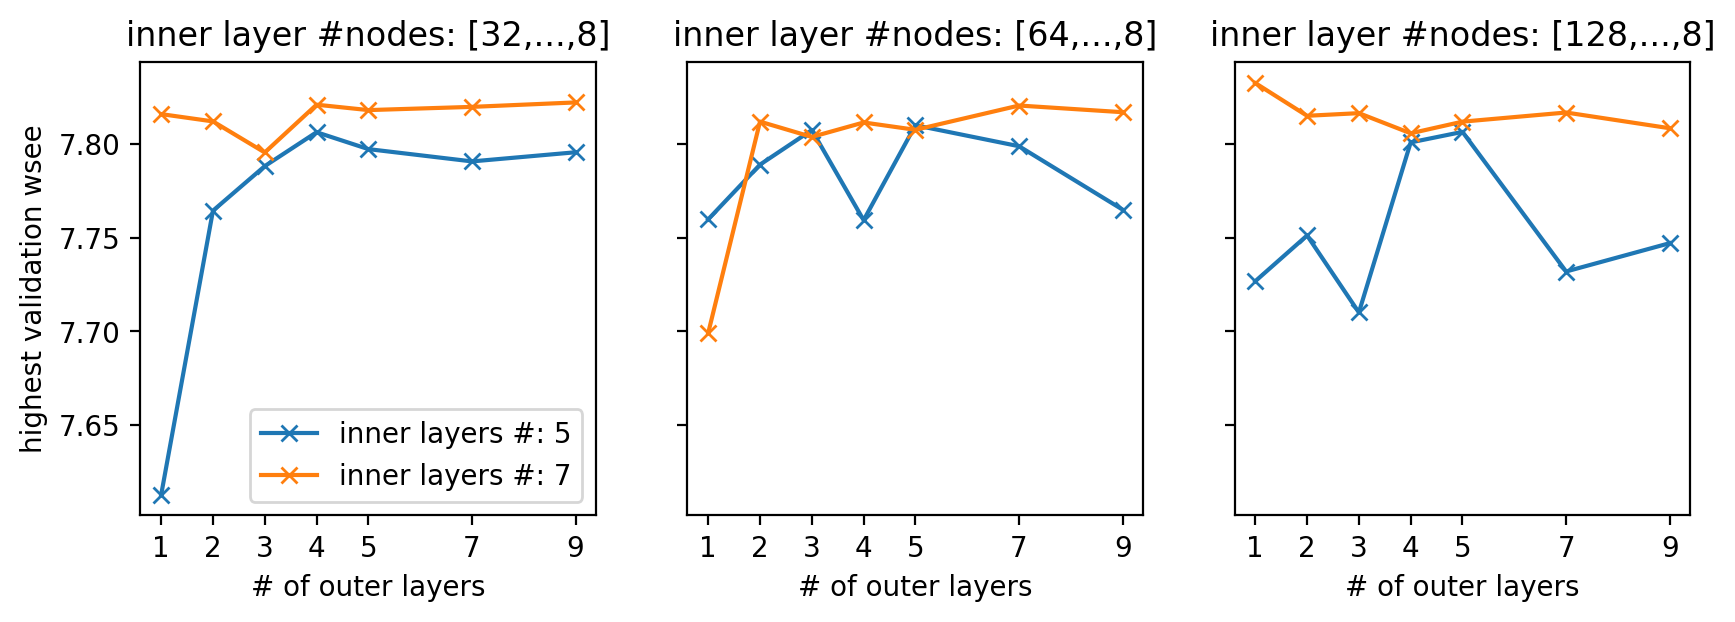

In [5]:

titstr = ['[32,...,8]', '[64,...,8]', '[128,...,8]']
fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=200, sharey=True)

for i in range(3):
    wsee = res_mat[np.unique(out_num), ...][:, np.unique(in_num),:][...,i]

    ax[i].plot(np.unique(out_num), wsee,'x-')
    
    ax[i].set_xticks(np.unique(out_num))
    ax[i].set_xlabel('# of outer layers')
    ax[i].set_title('inner layer #nodes: '+titstr[i])
    if i==0:
        ax[i].set_ylabel('highest validation wsee')
        ax[i].legend(['inner layers #: %d'%n for n in np.unique(in_num)])

## unfolded sca pipeline

In [50]:

import os
# os.listdir('./runs/')

from utils import *

In [51]:
# fix = "{model_name}_kf+{num_folds}_bs+{batch_size}_nl+{outer_nlayers}+{inner_nlayers}+{inner_num_nodes}_lr+{learning_rate:.2e}_l2+{l2:.2e}_pinit+{pt_initial}_loss+{loss_funcs}_rseed+{random_state}".format(
#     model_name=m_str, num_folds=k_fold, batch_size=bs, outer_nlayers=num_l, 
#     inner_nlayers=len(arc['h_sizes']), inner_num_nodes=str(arc['h_sizes']).replace(' ', ''), 
#     learning_rate=learning_rate, l2=l2, pt_initial=init, loss_funcs= '+'.join(loss_which), 
#     random_state=rseed)

import json

inner_layers=[32,16,8]
fk='*'

inner_layers_str = str(inner_layers).replace(' ','')

keys = ['GCN|mse', 'GCN|wsee','GCN|mse+wsee']
files = [f'./runs_test/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+mse_rseed+42/{fk}/logs.json',
         f'./runs_test/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json',
         f'./runs_test/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+mse+wsee_rseed+42/{fk}/logs.json']

keys = ['USCA-GCN|mse', 'USCA-GCN|wsee','USCA-GCN|mse+wsee']
files = [f'./runs_test/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+mse_rseed+42/{fk}/logs.json',
         f'./runs_test/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json',
         f'./runs_test/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+mse+wsee_rseed+42/{fk}/logs.json']

keys = ['GCN-USCA|wsee(max)','GCN-USCA|wsee(rand)', 'MLP-USCA|wsee', 'GCN-Vanilla|wsee(max)','GCN-Vanilla|wsee(rand)', 'MLP-Vanilla|wsee']
files = [
    glob.glob(glob_escape_except(f'./runs_10_test_corr/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json')),
    glob.glob(glob_escape_except(f'./runs_10_rand/USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+5.00e-04_l2+1.00e-06_pinit+rand_loss+wsee_rseed+42/{fk}/logs.json')),
    glob.glob(glob_escape_except(f'./runs_10/USCA.MLP+learned.mlp_kf+2_bs+512_nl+3+3+[32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json')),
    glob.glob(glob_escape_except(f'./runs_10_test/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json')),
    glob.glob(glob_escape_except(f'./runs_10_rand/GCN.ChPt+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+rand_loss+wsee_rseed+42/{fk}/logs.json')),
    glob.glob(glob_escape_except(f'./runs_10/MLP.ChPm+vanilla_kf+2_bs+512_nl+0+5+[128,64,32,16,8]_lr+5.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/{fk}/logs.json')),
]


evals = {}

# for kx, tl in zip(keys, files):
#     with open(tl, 'r') as fp:
#         evals[kx] = json.load(fp)

for kx, tl_list in zip(keys, files):
    evals[kx] = []
    for tl in tl_list:
        with open(tl, 'r') as fp:
            evals[kx].append( json.load(fp) )
            
            

## plot

## learning rate --> learning stability (any spikes in loss?)

In [111]:

# split train, val, test sets, same as run
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)
for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.ones(y_tr.shape[0], dtype=bool))):
    if k==0:
        # full sca
        wsee_sca = {'tr': np.nanmean(wsee_sca_tr), #[train_index]), #
                    'va': np.nanmean(wsee_sca_tr), #[valid_index]),
                    'te': np.nanmean(wsee_sca_te)} #[valid_index])}        
#         # truncated sca
#         args = {'mu':cinfo_tr['mu'], 'Pc':cinfo_tr['Pc'], 'init':'last', 
#                 'SolverMaxIter':len(inner_layers), 'MaxIter':1}
#         wsee_sca_trunc = {'tr': np.nanmean(classical_SCA(X_tr_[train_index], **args)[0]), 
#                           'va': np.nanmean(classical_SCA(X_tr_[valid_index], **args)[0]), 
#                           'te': np.nanmean(classical_SCA(X_te_[valid_index], **args)[0])}


In [299]:
import json
from pprint import pprint

kfolds=10
fk=list(range(kfolds))
inner_layers=[32,16,8]
inner_layers_str = str(inner_layers).replace(' ','')

learning_rates = [1e-4, 5e-4, 1e-3]#[2e-5, 5e-5, 1e-4, 5e-4]#
learning_rates_str = str(learning_rates).replace(' ','')

""" GCN-Vanilla """
#USCA.GCN+learned.gcn_kf+2_bs+512_nl+3+3+[32,16,8]_lr+5.00e-05_l2+1.00e-06_pinit+full_loss+wsee_rseed+42
keys = ['lr+%.2e'%(lr) for lr in learning_rates]
files = []
for k in keys:
    f = sorted(glob.glob(f'./runs_10_EXP+LR+SplitH/USCA*_kf+{kfolds}*+3+5*_*{k}*/*/logs.json'))
    if len(f)==0:
        keys.remove(k)
    elif len(f)<=kfolds:
        files.append(f)
#         files.append([f[fd] for fd in fk])
    else:
        raise

pprint(dict(zip(keys, files)))

evals = {}

for kx, tl_list in zip(keys, files):
    evals[kx] = []
    for tl in tl_list:
        with open(tl, 'r') as fp:
            evals[kx].append( json.load(fp) )


{'lr+1.00e-03': ['./runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/0/logs.json',
                 './runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/1/logs.json',
                 './runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/2/logs.json',
                 './runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/3/logs.json',
                 './runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-03_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/4/logs.json'],
 'lr+1.00e-04': ['./runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/0/log

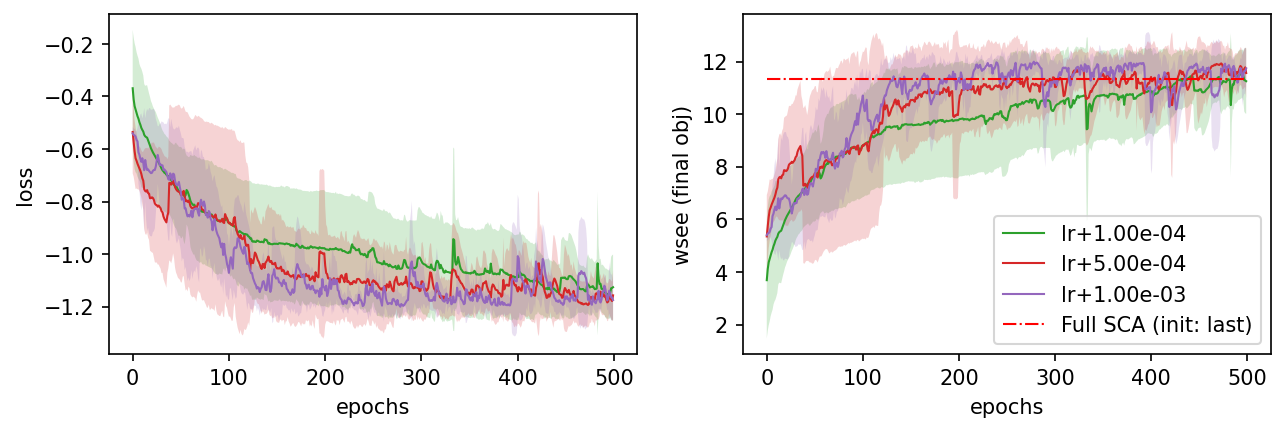

In [302]:
import numpy as np
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ph='va'

plt.figure(figsize=(10,3), dpi=150)
axes = plt.subplot(121)
main_axes = plt.subplot(122)
# sub_axes = plt.axes([.97, .55, .3, .3]) # location for the zoomed portion 

for i, (exper, vals) in enumerate(evals.items()):
    extra_args = { 'label':exper, 'color':colors[2+i]}
    #mse = np.array(vals['loss'][ph])       
    mse = list2arr([v['loss'][ph] for v in vals])
    plot_shaded(x=range(mse.shape[-1]), y=mse, ax=axes, **extra_args)
    
    #wsee = np.array(vals['wsee'][ph])
    wsee = list2arr([v['wsee'][ph] for v in vals])
    plot_shaded(x=range(wsee.shape[-1]), y=wsee, ax=main_axes, **extra_args)
    
#     sub_axes.plot(wsee_m)
     
xs = [0, wsee.shape[-1]]
# wsee_opt = vals['wsee_opt']
for ax in [main_axes]:#, sub_axes]:
#     # zoom in, box and arrow
#     ax.plot(xs, [wsee_opt[ph]]*2, 'k--', label='Global opt', linewidth=1)
#     ax.plot(xs, [wsee_sca_trunc[ph]]*2, 'c-.', label='Truncated SCA (init: last)', linewidth=1)
    ax.plot(xs, [wsee_sca[ph]]*2, 'r-.', label='Full SCA (init: last)', linewidth=1)

# s_lo, s_hi = wsee_sca_trunc[ph]-.1, wsee_opt[ph]+.1
# sub_axes.set_ylim([s_lo, s_hi])
# sub_axes.set_xlim([300,500])
# sub_axes.set_xticks(np.arange(300,501,50))

# main_axes.annotate('', xy=(1.05,.79), xycoords='axes fraction', xytext=(.9, .895), arrowprops=dict(arrowstyle="->"))
# main_axes.text(250, s_lo, ' '*35, color='k', bbox=dict(facecolor='none', edgecolor='gray', pad=5.0))

axes.set_xlabel('epochs')
main_axes.set_xlabel('epochs')
# axes.set_yscale('log')
# axes.set_ylabel('mse (pred allocation vs true)')
axes.set_ylabel('loss')
# # main_axes.set_xscale('log')
main_axes.set_ylabel('wsee (final obj)')
main_axes.legend(loc='lower right')#bbox_to_anchor=(1.4, .32), loc='upper left')

plt.show()

In [119]:
files


[['./runs_10_EXP+LR+SplitH/USCA.GCN+learned.gcn_kf+10_bs+5120_nl+3+5+[16,64,32,16,8]_lr+1.00e-04_l2+1.00e-06_pinit+full_loss+wsee_rseed+42/3/logs.json']]

In [121]:
 valid_i[:51*4]

array([ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 28

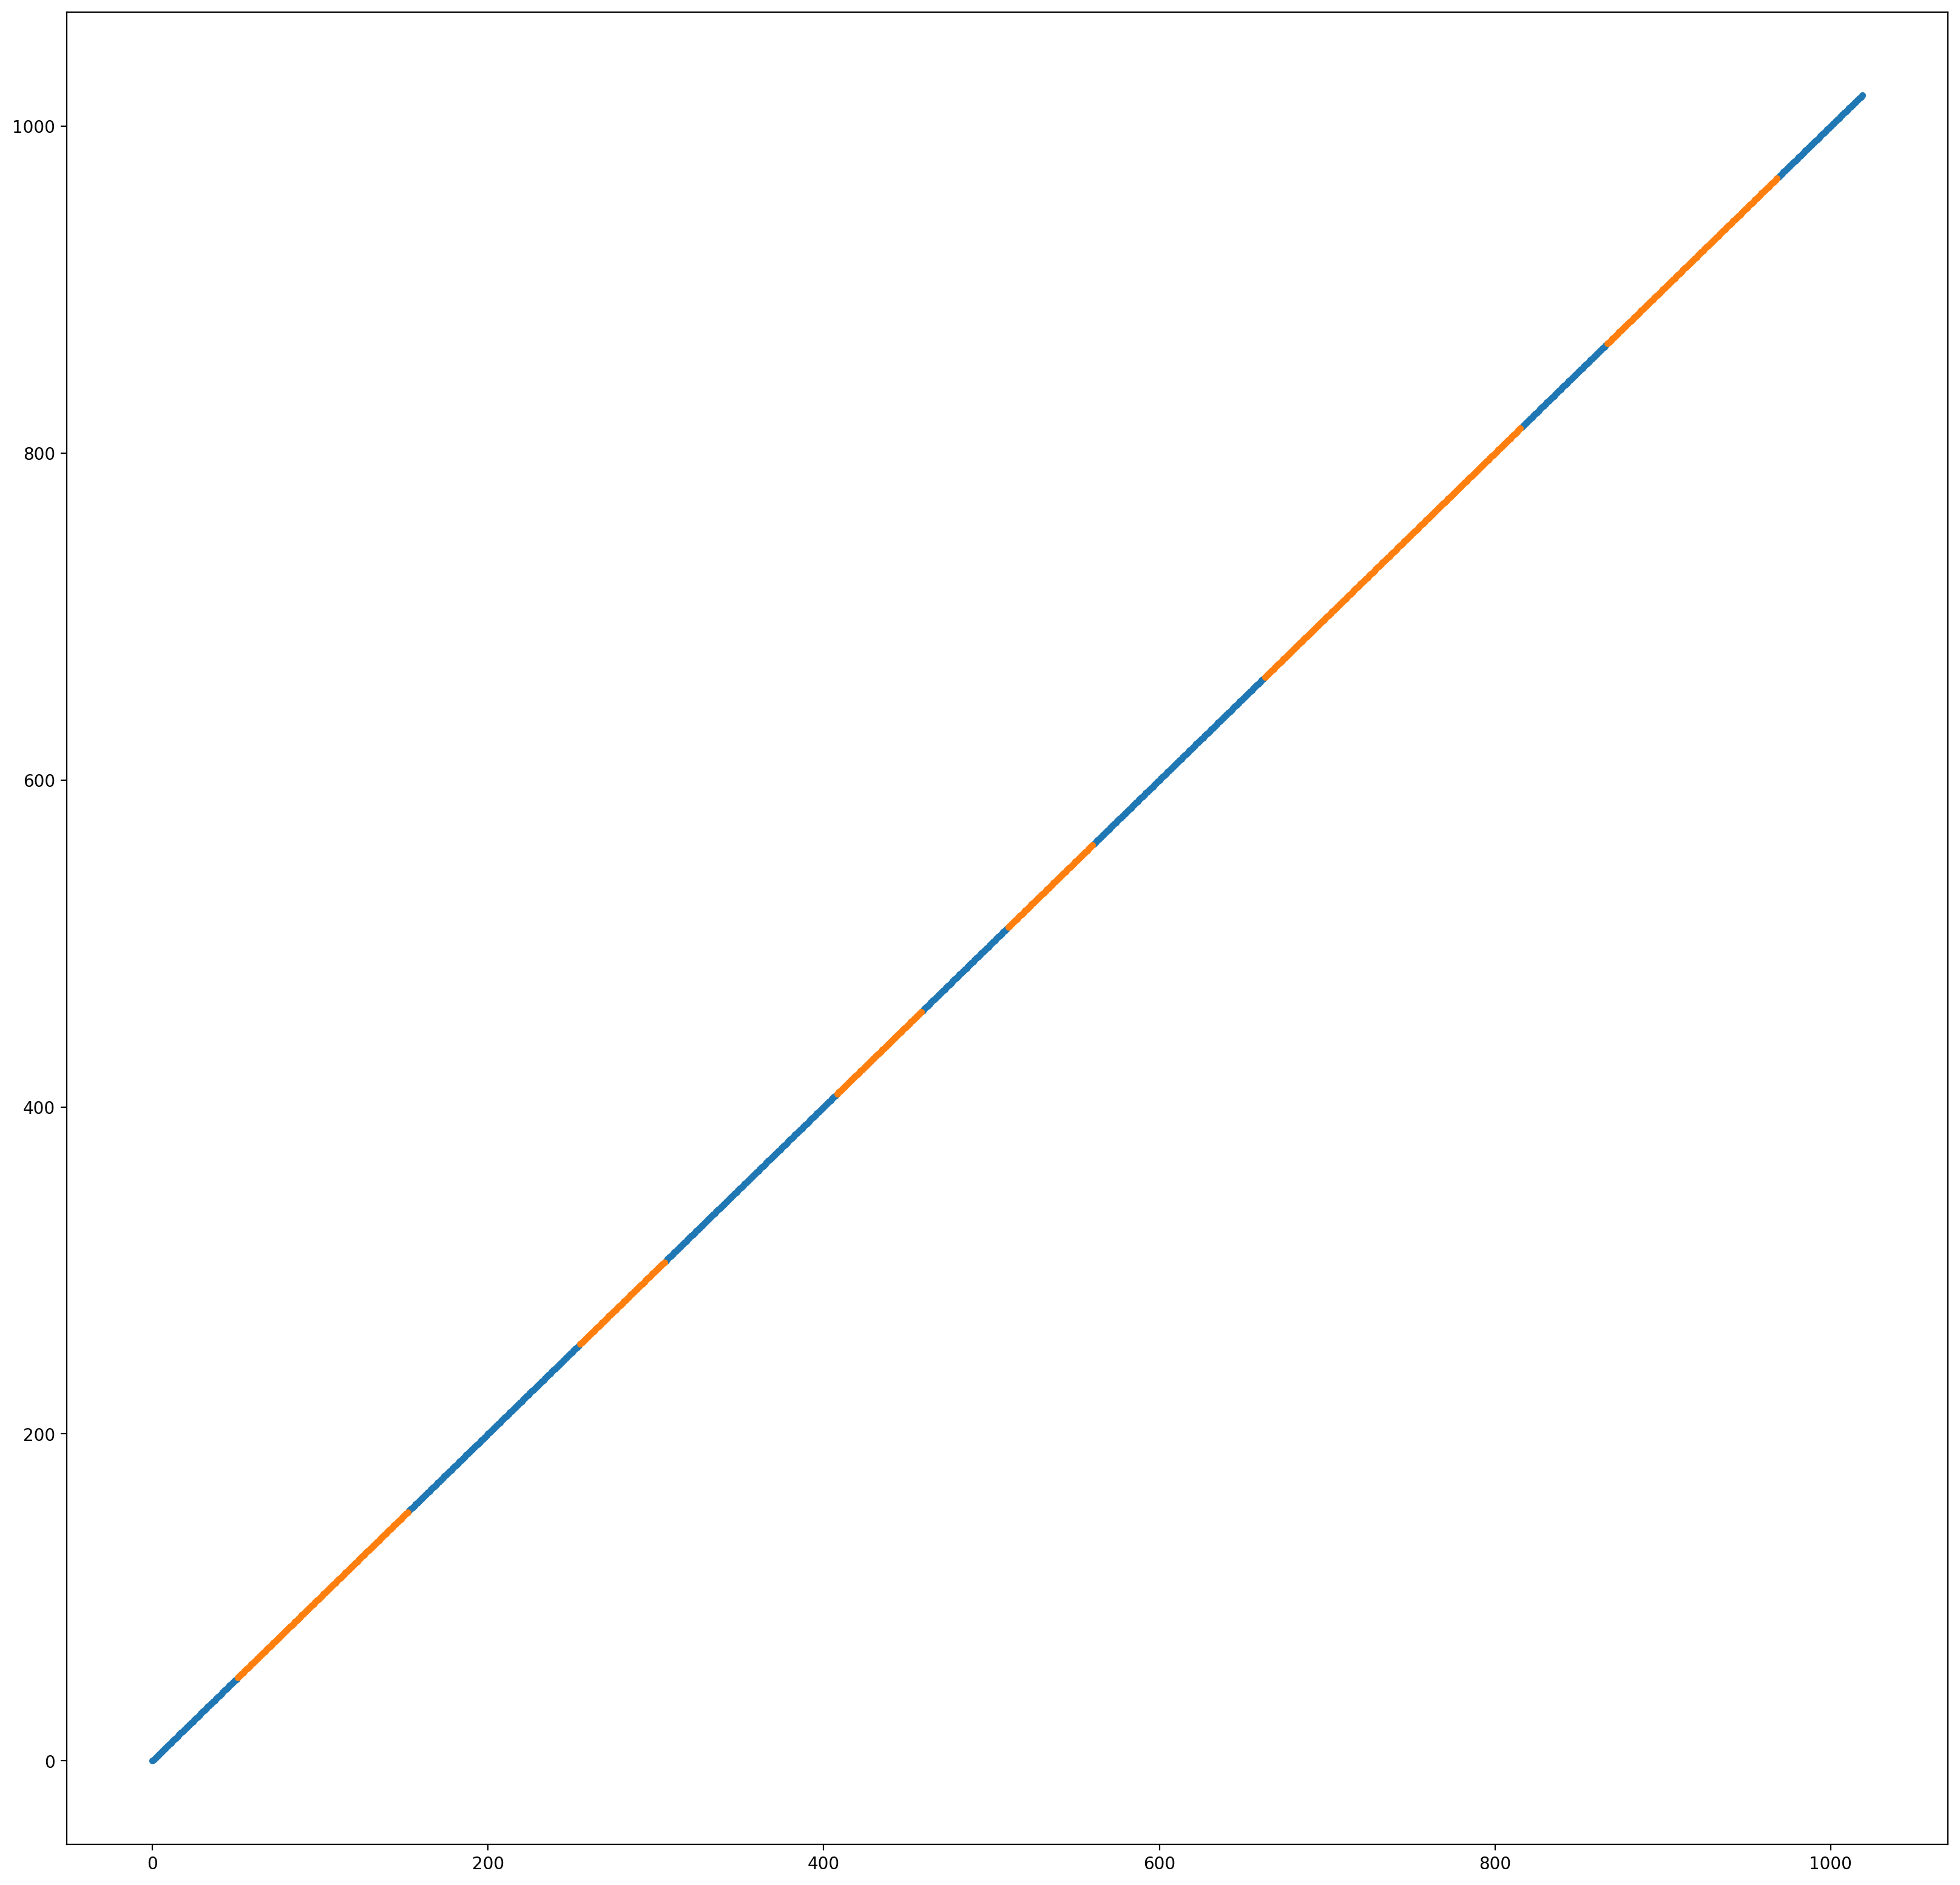

In [149]:
plt.figure(figsize=(20,20),dpi=200)

xt = 10

disp_t = -np.ones(int(51*xt*2.5))
disp_t[train_i[:51*xt]] = train_i[:51*xt]
disp_t[disp_t==-1]=np.nan
plt.plot(disp_t, '.')

disp_v = -np.ones(int(51*xt*2.5))
disp_v[valid_i[:51*xt]] = valid_i[:51*xt]
disp_v[disp_v==-1]=np.nan
# disp_v[~valid_i[:51*4]] = np.nan

plt.plot(disp_v, '.')


In [148]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for k, (train_index, valid_index) in enumerate(skf.split(X_tr_.reshape(X_tr_.shape[0]//51, -1), np.ones(y_tr.shape[0]//51, dtype=bool))):
    train_i  = np.concatenate([np.arange(ti*51, (ti+1)*51) for ti in train_index])
    valid_i  = np.concatenate([np.arange(vi*51, (vi+1)*51) for vi in valid_index])


In [100]:
valid_index[:300]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18